## Real Estate Room Type Classification on Redfin Data

Here, we intend to build a real estate classification model similar to one build by cohort 13. The aim is to classify the room images into 7 base classes - kitchen, bathroom, bedroom, dining_room, living_room, Exterior and Interior. 
We use the unlabelled dataset collected by previous team from redfin website. The data was stored in terms of 19 batch wise folders, where each folder contained 1000 listings and each listings contained ~20 images.

For the purpose of labelling, we run prediction using pre-trained model on set of 20000 images of any one batch. We visually correct labeling for half of data. Except Interior, other classes are easily identifiable. We classify Interior rooms as the ones which have features such as - attic, washer_dryer room,  study tables, children room, staircases, entrances, foyers,etc.
In cases where images have no furnitures, we choose interior as one which is not visually identifiable into other categories, like images with windows or rooms with sloped ceiling

Additionally, we use annoy to label data. This is done by finding similar images from unlabelled sample for a given sample of train images. We then use the label of train image in order to label test images.

The train data was laballed from one batch and for validation we use data from another batch. This way, We were able to gather 3000 labelled images. We have trained model on top of pretrained model of previous cohort. With this, we could reach ~85% accuracy, although more work needs to be done.

### Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt
import seaborn as sns

### Getting data

In [2]:
PATH = Path('batch_images/redfin/')
PATH

PosixPath('batch_images/redfin')

In [205]:
import pandas as pd
import glob

all_files = glob.glob("Redfin Real*.csv")

train_li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=False)
    df= df[['file_name','labeled_class']]
    train_li.append(df)

train_df = pd.concat(train_li, axis=0, ignore_index=True)

In [206]:
train_df.head(), train_df.shape

(     file_name labeled_class
 0  5407_37.jpg      bathroom
 1  5078_20.jpg      interior
 2   5803_3.jpg      bathroom
 3  5650_19.jpg      bathroom
 4  5103_31.jpg      exterior, (6000, 2))

**Preprocessing steps**

In [207]:
train_df.loc[train_df.labeled_class.isnull()].shape

(27, 2)

In [208]:
train_df.dropna(inplace=True)

In [209]:
train_df[train_df.duplicated()].shape

(1957, 2)

In [210]:
train_df.drop_duplicates(inplace=True)

In [211]:
train_df.shape

(4016, 2)

In [212]:
df = train_df
df.shape

(4016, 2)

In [213]:
df.groupby('labeled_class').count()

,file_name
labeled_class,
bathroom,420
bedroom,436
dining room,268
exterior,1302
interior,802
kitchen,417
living room,371


In [214]:
tfms = get_transforms(do_flip=False,xtra_tfms=rand_resize_crop(224))

In [217]:
np.random.seed(42)
data = (ImageList.from_df(df,PATH).split_by_rand_pct(0.05)
       .label_from_df().transform(tfms,size=224)
        .databunch(bs=4).normalize(imagenet_stats))

In [218]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList (3816 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bathroom,interior,bathroom,bathroom,exterior
Path: batch_images/redfin;

Valid: LabelList (200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dining room,interior,exterior,interior,living room
Path: batch_images/redfin;

Test: None>

In [219]:
print(f'Dataset has {data.c} classes: {data.classes}')

Dataset has 7 classes: ['bathroom', 'bedroom', 'dining room', 'exterior', 'interior', 'kitchen', 'living room']


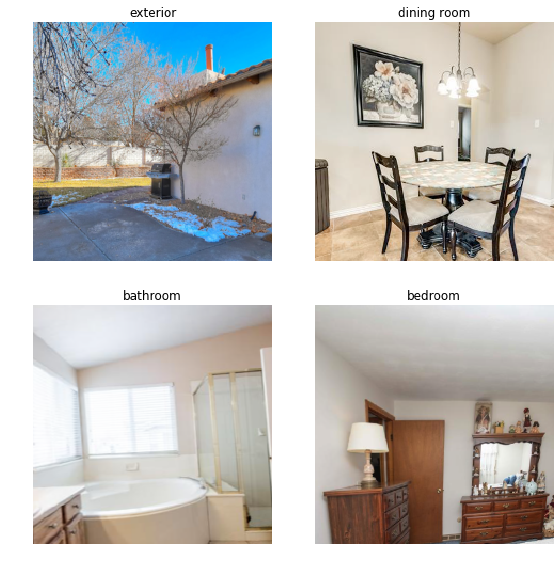

In [220]:
data.show_batch()

### Training the model

We first train only last few layers and later unfreeze and train the whole network.We will try out various pretrained models to in order to the best possible result

**Using DenseNet121**

In [221]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy, model_dir = Path('models').absolute())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


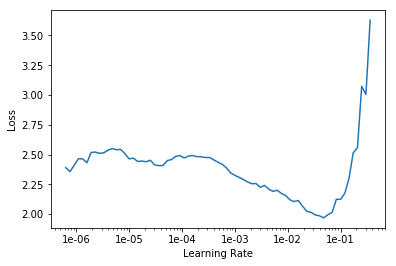

In [222]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.020186,0.673389,0.790000,04:00
1,0.882380,0.601931,0.815000,03:59
2,0.804230,0.504015,0.835000,04:01
3,0.824421,0.492630,0.855000,04:01
4,0.733723,0.492246,0.850000,04:02


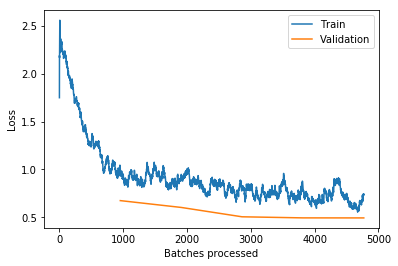

In [223]:
learn.fit_one_cycle(5,max_lr=slice(1e-03))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.748049,0.495815,0.875000,03:45
1,0.685913,0.466297,0.860000,03:36
2,0.557927,0.481249,0.880000,03:32


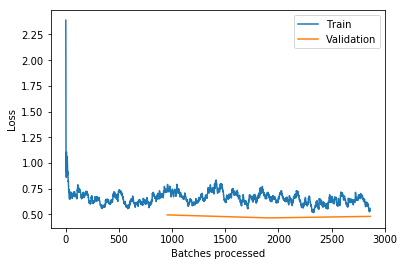

In [225]:
learn.fit_one_cycle(3,max_lr=slice(1e-03))
learn.recorder.plot_losses()

In [226]:
learn.save('redfin-dn121-stage-1')

In [81]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


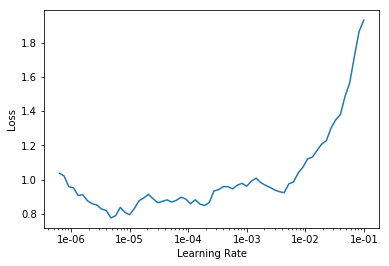

In [82]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(5, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.275079,2.190305,0.294118,02:10
1,2.012352,2.077253,0.217195,02:09
2,1.833502,2.267571,0.285068,02:10
3,1.721504,1.704654,0.348416,02:09
4,1.629676,1.615610,0.375566,02:09


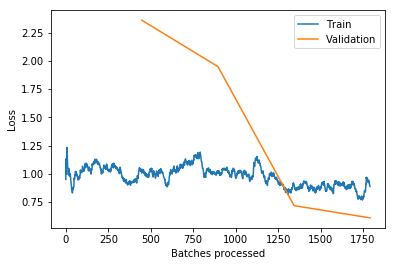

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.save('redfin-dn121-stage-2')

**Using pretrained resnet50**

In [163]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir = Path('models').absolute())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


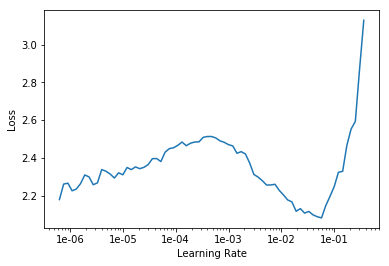

In [164]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.165572,0.677737,0.791855,01:54
1,0.993158,0.532922,0.805430,01:54
2,0.849805,0.447786,0.841629,01:53
3,0.886646,0.427644,0.873303,01:54
4,0.858863,0.423127,0.859729,01:52


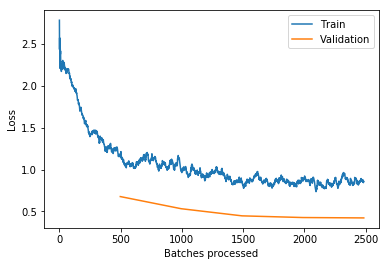

In [165]:
learn.fit_one_cycle(5,max_lr=slice(1e-03))
learn.recorder.plot_losses()

In [ ]:
learn.save('redfin-rn50-stage-1')

In [40]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


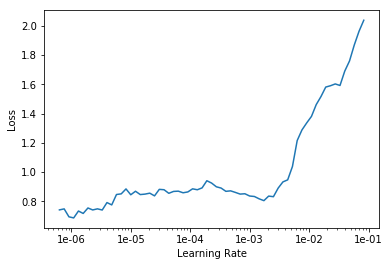

In [41]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.128309,0.738291,0.773869,01:44
1,1.368728,1.607861,0.507538,01:45
2,1.190313,0.786859,0.723618,01:45
3,0.941592,0.634708,0.773869,01:43
4,0.788422,0.579843,0.834171,01:44


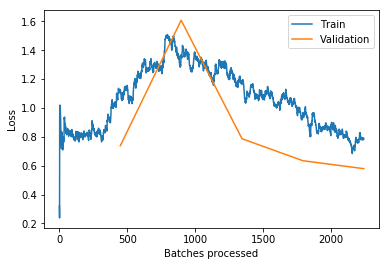

In [42]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))
learn.recorder.plot_losses()

**Using DenseNet161**

In [166]:
learn = cnn_learner(data, models.densenet161, metrics=accuracy, model_dir = Path('models').absolute())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


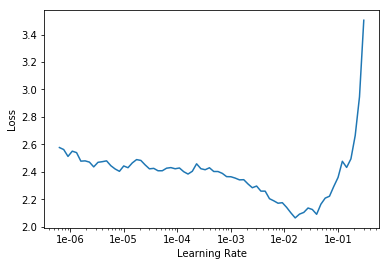

In [168]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.022203,0.468691,0.864253,02:23
1,0.992001,0.505963,0.832579,02:23
2,0.823450,0.445137,0.855204,02:21
3,0.793202,0.429646,0.864253,02:23
4,0.638832,0.408865,0.864253,02:23
5,0.663176,0.409229,0.873303,02:23


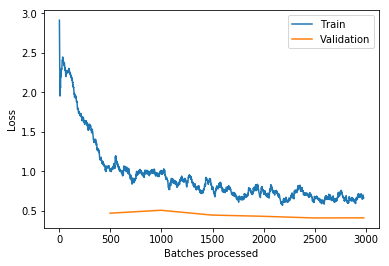

In [169]:
learn.fit_one_cycle(6,max_lr=slice(1e-03))
learn.recorder.plot_losses()

In [48]:
learn.save('redfin-dn161-stage-1')

### Results

In [227]:
learn.load('redfin-dn121-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (3816 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bathroom,interior,bathroom,bathroom,exterior
Path: batch_images/redfin;

Valid: LabelList (200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dining room,interior,exterior,interior,living room
Path: batch_images/redfin;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=

In [228]:
interp = ClassificationInterpretation.from_learner(learn)

In [229]:
interp.most_confused()

[('bedroom', 'interior', 3),
 ('kitchen', 'dining room', 3),
 ('bathroom', 'interior', 2),
 ('bedroom', 'living room', 2),
 ('exterior', 'interior', 2),
 ('interior', 'living room', 2),
 ('kitchen', 'interior', 2),
 ('living room', 'bedroom', 2),
 ('bathroom', 'kitchen', 1),
 ('bedroom', 'kitchen', 1),
 ('dining room', 'interior', 1),
 ('dining room', 'kitchen', 1),
 ('exterior', 'living room', 1),
 ('interior', 'bathroom', 1)]

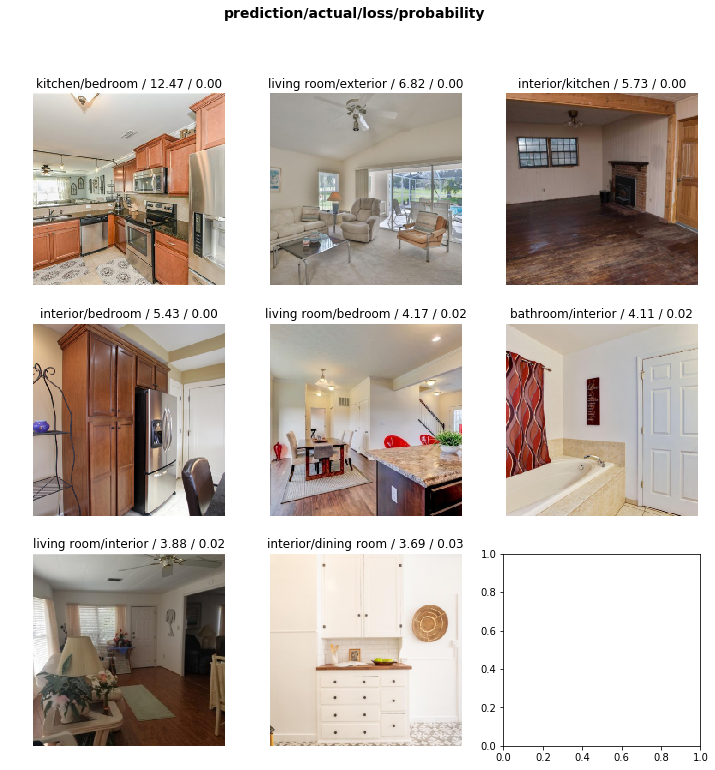

In [239]:
interp.plot_top_losses(8,heatmap=False)

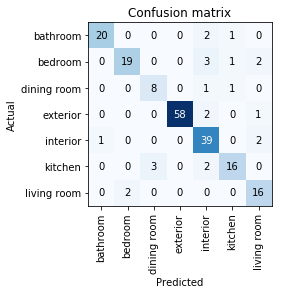

In [231]:
interp.plot_confusion_matrix()

### Key Observations

1. From the most confused output, we see that interior and bedroom gets confused a lot. We believe, this is mainly in cases where rooms are empty, few rooms were labelled as interior and few of them where labelled as bedrooms. Since the rooms are mainly empty, there isnt any main distinguishing feature between the 2 classes. The same would be the case for living room and interior comparision
2. From losses plot, i see that train and validation loss seems to settle down. At the end, validation loss seems to increase slightly, implying overfitting. I believe training on more data should give us better results
3. Additionally, from top losses plot, looks like there is issue in the labeled data causing incorrect classification and this would have to be manually corrected